In [1]:
import pandas as pd
import sqlite3
import numpy as np
from shapely.geometry import Point
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import math # for haversine function
import folium  # heat map
from folium.plugins import HeatMap  # heat map


# my custom file
#import Mapping_tools

In [378]:
# Database paths
# ALEX'S PATH
database_db = 'blue_bikes.db'
# ZACK'S PATH
database_db = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/blue_bikes.db'


# SHARED GITHUB PATHS - should work for all users
# Physical geographies
boston_city_shp = "https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/Boston_Neighborhoods/Boston_Neighborhoods.shp"
water_boundaries_path = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/Background_map_data/Hydrography_(Polygon)/Hydrography_(Polygon).shp'
munis_path = '/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/Background_map_data/townssurvey_shp/TOWNSSURVEY_POLY.shp'
# Sea Level Rise
sea_level_9in_path = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/9_inch_SLR_10_pct_storm/_9inch_Sea_Level_Rise_10pct_Annual_Flood.shp'
sea_level_21in_path = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/21_inch_SLR_10_pct_storm/_21inch_Sea_Level_Rise__10pct_Annual_Flood.shp'
sea_level_36in_path = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/36_inch_SLR_10_pct_storm/_36inch_Sea_Level_Rise_10pct_Annual_Flood.shp'
# Other layers
bike_lanes_geojson = 'https://github.com/ZacharyArmandNEU/DS5110-blue-bikes/raw/f4c5e5a775e419caf08a19249ac2dc141038fbe1/Data/bos-bike-paths-2022.geojson'



In [379]:
# Connection to database:
con = sqlite3.connect(database_db)

In [380]:
# Here are all the Views:
# Filter crash data to just bikes
boston_crashes_2017 = pd.read_sql("SELECT * FROM boston_crash_reports_2017 WHERE mode_type = 'bike'", con)
boston_crashes_2022 = pd.read_sql("SELECT * FROM boston_crash_reports_2022", con)
boston_fatalities_2017 = pd.read_sql("SELECT * FROM boston_fatality_report_2017", con)
boston_fatalities_2022 = pd.read_sql("SELECT * FROM boston_fatality_report_2022", con)
bike_5001 = pd.read_sql("SELECT * FROM bike_5001", con)

# Tables:
bluebike_trips2017 = pd.read_sql("SELECT * FROM bluebike_trips2017", con)
bluebike_trips2022 = pd.read_sql("SELECT * FROM bluebike_trips2022", con)
boston_crash_reports = pd.read_sql("SELECT * FROM boston_crash_reports", con)
boston_fatality_report = pd.read_sql("SELECT * FROM boston_fatality_report", con)
current_bluebikes_stations = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)

<Axes: >

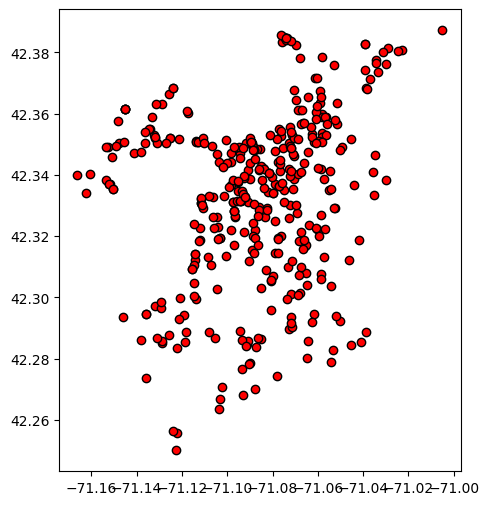

In [364]:
# Convert crash dataframe into a series of point objects
points = [Point(xy) for xy in zip(boston_crashes_2017['long'], boston_crashes_2017['lat'])]
# Convert that point layer into a geodataframe object
geodf = gpd.GeoDataFrame(boston_crashes_2017,
                             crs="EPSG:4326",
                             geometry=points)

fig, ax = plt.subplots(figsize=(7, 6))
#geodf.plot(color='#808080', edgecolor='#000000', ax=ax)  # background plot
# Plot data
geodf.plot( edgecolor='#000000',
          legend=True, categorical=False, ax=ax, color='r')

# Stuff We Like - so far? needs to be cleaned up still?

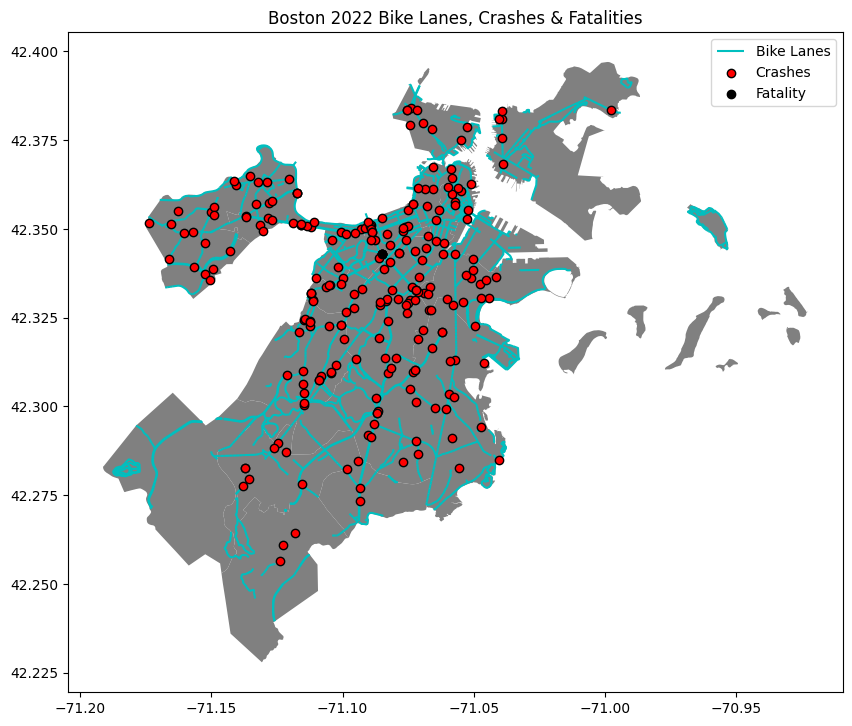

In [365]:
# read in data
boston_crash_reports = pd.read_sql("SELECT * FROM boston_crash_reports", con)
boston_crash_reports = boston_crash_reports[boston_crash_reports["mode_type"] == 'bike']

# convert datetime data type
boston_crash_reports['dispatch_ts'] = pd.to_datetime(boston_crash_reports['dispatch_ts'])

# filter the dataframe for the year 2022
filtered_data = boston_crash_reports[boston_crash_reports['dispatch_ts'].dt.year == 2022]

# Mapping a dataframe with lat/long data to a point file
points = [Point(xy) for xy in zip(filtered_data['long'], filtered_data['lat'])]

# Convert that point layer into a geodataframe object
crashes_22 = gpd.GeoDataFrame(filtered_data, crs="EPSG:4326", geometry=points)


# repeat step above for fatalies data
boston_fatality_report = pd.read_sql("SELECT * FROM boston_fatality_report", con)
boston_fatality_report = boston_fatality_report[boston_fatality_report["mode_type"] == 'bike']

# convert datetime data type
boston_fatality_report['date_time'] = pd.to_datetime(boston_fatality_report['date_time'])

# filter the dataframe for the year 2022
filtered_fatality = boston_fatality_report[boston_fatality_report['date_time'].dt.year == 2022]

# Mapping a dataframe with lat/long data to a point file
fatality_points = [Point(xy) for xy in zip(filtered_fatality['long'], filtered_fatality['lat'])]
# Convert that point layer into a geodataframe object
fatalities_22 = gpd.GeoDataFrame(filtered_fatality, crs="EPSG:4326", geometry=fatality_points)

# Read in bike lanes file
bike_lanes = gpd.read_file(bike_lanes_geojson)

# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = gpd.read_file(boston_city_shp, type='Polygon')
boston_neighborhoods = boston_neighborhoods.to_crs('EPSG:4326')

# create figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Plot background images
bike_lanes.plot(ax=ax, color='c')
boston_neighborhoods.plot(ax=ax, color='grey')

# Plot data
crashes_22.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='r', zorder=4)
fatalities_22.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='k', zorder=5)
plt.title("Boston 2022 Bike Lanes, Crashes & Fatalities")
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Bike Lanes", "Crashes", "Fatality"], loc=0, frameon=legend_drawn_flag)
plt.show()

In [205]:
# SEA LEVEL RISE MAPPING AND DATA

# Filter crash data to just bikes
stations = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)

# Mapping a dataframe with lat/long data to a point file
points = [Point(xy) for xy in zip(stations['Longitude'], stations['Latitude'])]
# Convert that point layer into a geodataframe object
stations = gpd.GeoDataFrame(stations, crs="EPSG:4326", geometry=points)



# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = gpd.read_file(boston_city_shp, type='Polygon')
boston_neighborhoods = boston_neighborhoods.to_crs('EPSG:4326')




# Add 9 inch level rise 10 pct storm
sea_level_9in = gpd.read_file(sea_level_9in_path, type='Polygon')
sea_level_9in = sea_level_9in.to_crs('EPSG:4326')
# Add 21 inch level rise 10 pct storm
sea_level_21in = gpd.read_file(sea_level_21in_path, type='Polygon')
sea_level_21in = sea_level_21in.to_crs('EPSG:4326')
# Add 36 inch level rise 10 pct storm
sea_level_36in = gpd.read_file(sea_level_36in_path, type='Polygon')
sea_level_36in = sea_level_36in.to_crs('EPSG:4326')


clipped_stations = gpd.clip(stations, boston_neighborhoods, keep_geom_type=False)
# Spatially clip the points to the polygons
clipped_stations_SLR9 = gpd.clip(clipped_stations, sea_level_9in, keep_geom_type=False)
clipped_stations_SLR21 = gpd.clip(clipped_stations, sea_level_21in, keep_geom_type=False)
clipped_stations_SLR36 = gpd.clip(clipped_stations, sea_level_36in, keep_geom_type=False)

# number of stations underwater!
print(clipped_stations_SLR9.count()[0], "stations impacts by 9 inch sea level rise 10 percent storm!")
print(clipped_stations_SLR21.count()[0], "stations impacts by 21 inch sea level rise 10 percent storm!")
print(clipped_stations_SLR36.count()[0], "stations impacts by 36 inch sea level rise 10 percent storm!")

8 stations impacts by 9 inch sea level rise 10 percent storm!
23 stations impacts by 21 inch sea level rise 10 percent storm!
54 stations impacts by 36 inch sea level rise 10 percent storm!


-71.08255059 -71.01063069
42.31886468 42.38522394


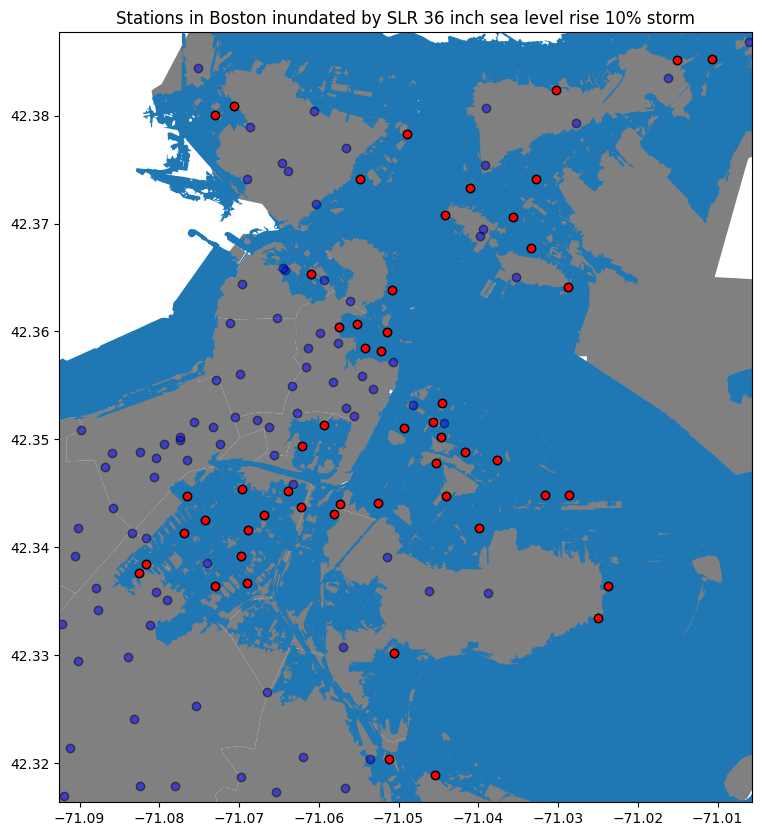

In [219]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# Neighborhood background map
#nhoods.plot(color='#808080', edgecolor='#000000', ax=ax)  # background plot

# Plot background images
#bike_lanes.plot(ax=ax)
boston_neighborhoods.plot(ax=ax, color='grey', zorder=1)
sea_level_36in.plot(ax=ax, zorder=2)

# Plot data
clipped_stations.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='b', alpha=0.5, zorder=4)
clipped_stations_SLR36.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='r', zorder=4)
plt.title("Stations in Boston inundated by SLR 36 inch sea level rise 10% storm")


# set zoom to just the waterfront area
minx, miny, maxx, maxy = clipped_stations_SLR36.total_bounds
print(minx, maxx)
print(miny, maxy)

ax.set_xlim(minx-0.01, maxx+0.005)
ax.set_ylim(miny-0.0025, maxy+0.0025)


plt.show()

## Zack's Work In Progress Stuff

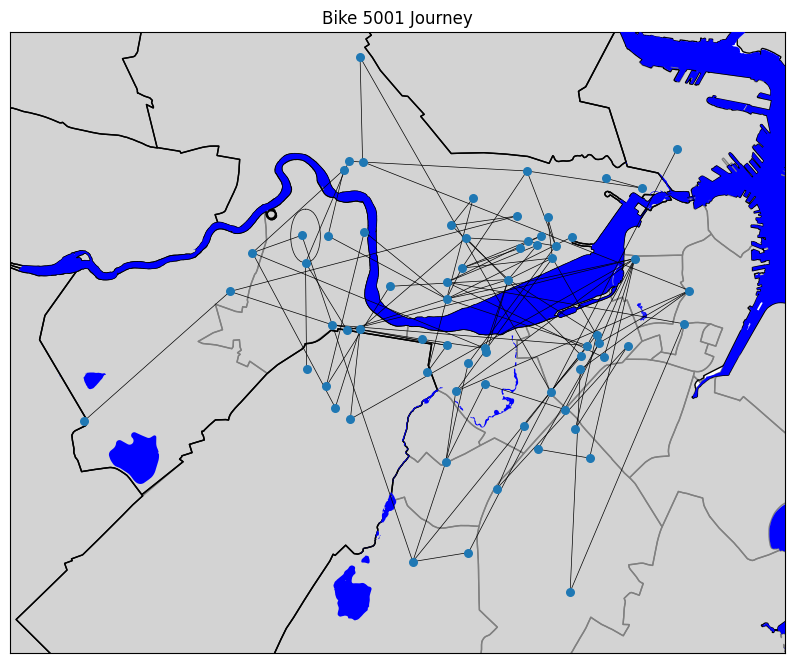

In [381]:
bike5001_network = pd.read_sql("SELECT * FROM bike_5001 ORDER BY starttime LIMIT 100", con)

G = nx.Graph()

for _, row in bike5001_network.iterrows():
  # Add the nodes to the graph
  G.add_node(row.start_station_name, pos=(row.start_station_longitude, row.start_station_latitude))
  G.add_node(row.end_station_name, pos=(row.end_station_longitude, row.end_station_latitude))

  # Add the edge between start_station and end_station
  G.add_edge(row.start_station_name, row.end_station_name)


# Draw the figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
#plt.figure(figsize=(10,10), dpi=100)
plt.title("Bike 5001 Journey")


# https://data.boston.gov/dataset/hydrography-polygon
water = gpd.read_file(water_boundaries_path, type='Polygon')
water = water.to_crs('EPSG:4326')
water.plot(ax=ax, color='blue', zorder=5)
# https://www.mass.gov/info-details/massgis-data-municipalities
munis = gpd.read_file(munis_path, type='Polygon')
# filter towns so it's not a massive file
munis = munis.query("TOWN in ('BOSTON', 'CAMBRIDGE', 'BROOKLINE',\
                    'NEWTON', 'WATERTOWN', 'SOMERVILLE',\
                    'BELMONT', 'CHELSEA', 'EVERETT')")
munis = munis.to_crs('EPSG:4326')
# Plot only the internal color
munis.plot(ax=ax, color='lightgrey', edgecolor="None", zorder=1)
# Neighborhoods
boston_neighborhoods.plot(ax=ax, color='None', edgecolor="grey", zorder=2)
# Plot towns again - only the border
munis.plot(ax=ax, color='None', edgecolor="black", linewidth=1, zorder=3)


# Network
position = nx.get_node_attributes(G, 'pos')
# Draw edges and nodes
nodes = nx.draw_networkx_nodes(G, position, node_size=30)
edges = nx.draw_networkx_edges(G, position, node_size=30, width=0.5, edge_color='black')
nodes.set_zorder(10)
edges.set_zorder(9)

#minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(-71.18, -71.045)
ax.set_ylim(42.31, 42.39)
        
# Add legend    
plt.show()

Note to self: Sea level rise next step includes joining inundated stations to the full table, and then getting the number of trips generated from these stations. 

Then, compare the number of trips generated from these stations to the total number of trips taken.

In [10]:
# List of stations that have been inundated
filter_criteria = list(clipped_stations_SLR36['Name'])
# Get full data for inundated stations
inundated_stations = stations[stations['Name'].isin(filter_criteria)]
# Get rides lost due to SLR in 2022
start_station_filter = bluebike_trips2022['start_station_name'].isin(filter_criteria)
end_station_filter = bluebike_trips2022['end_station_name'].isin(filter_criteria)

# Filter for start and end stations that are inundated
lost_trips = bluebike_trips2022[start_station_filter | end_station_filter]

# NUMBER OF TRIPS LOST!
print("There were", lost_trips.shape[0], "trips lost to a 10% storm with 36 inch SLR (2022 trips)")
prct_trips = lost_trips.shape[0] / bluebike_trips2022.shape[0] * 100  # number now in percent not decimal
print(f"This accounts for {prct_trips:.2f}% of total trips in 2022")



There were 680913 trips lost to a 10% storm with 36 inch SLR (2022 trips)
This accounts for 18.12% of total trips in 2022


### Trying to determine distance traveled for each trip and summing up by year

In [11]:
# Thanks professor! 
# Don't know how much to change or how to properly credit this
def haversine(lat1, lon1, lat2, lon2):

    # convert string to float - zack added to function
    lat1 = float(lat1)
    lon1 = float(lon1)
    lat2 = float(lat2)
    lon2 = float(lon2)
    
    
    radius_earth = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius_earth * c

    return d


# I made this so that I don't have to write out this process twice for each year of data
def trip_dist_calc(df):
    """
    Creates a column "trip_distance" in inputted dataframe
    Operates under the assumtion that the lat/long columns names are the same for each df
        They should be, I created them in a standardized way.
    Modifies dataframe in place, no need to return anything.
    """
    
    df['trip_distance'] = df.apply(lambda row: haversine(row['start_station_latitude'], 
                                                                                    row['start_station_longitude'], 
                                                                                    row['end_station_latitude'],
                                                                                    row['end_station_longitude']),
                                                               axis=1)

In [12]:
# Apply haversine function to start and end stations. Column is in kilometers
trip_dist_calc(bluebike_trips2017)
trip_dist_calc(bluebike_trips2022)

Data from EPA: 
"How much tailpipe carbon dioxide (CO2) is emitted from driving one mile?
 The average passenger vehicle emits about 400 grams of CO2 per mile."
 
Also from EPA: 
"A typical passenger vehicle emits about 4.6 metric tons of CO2 per year."
 
Source: https://www.epa.gov/greenvehicles/tailpipe-greenhouse-gas-emissions-typical-passenger-vehicle

Not trying to filter out trips that start and end at the same station. This calculation is fundamentally an underestimate because it calculates linear distance between stations, not actual total distance travelled. So, trips that start and end at the same station won't add anything to the calculation, so not worth editing out.

In [13]:
# for background, get number of trips each year (number of rows in dataframe)
trips2017 = int(bluebike_trips2017.shape[0])
trips2022 = int(bluebike_trips2022.shape[0])

# get total kilometers traveled and covert to miles (converstion factor: 0.621371)
trip_mi_2017 = int(bluebike_trips2017['trip_distance'].sum() * 0.621371)
trip_mi_2022 = int(bluebike_trips2022['trip_distance'].sum() * 0.621371)

# get total emissions saved from based on average vehicle tailpipe emission per mile
total_emissions_2017 = int(400 * trip_mi_2017 / 1000000)  # convert from grams to metric tonnes
total_emissions_2022 = int(400 * trip_mi_2022 / 1000000)  # convert from grams to metric tonnes

# for kicks, did average trip length increase between 2022 and 2017
avg_trip_len_2017 = trip_mi_2017 / trips2017
avg_trip_len_2022 = trip_mi_2022 / trips2022


# create a table with all this info
tripdata = pd.DataFrame({'2017': [trips2017, trip_mi_2017, total_emissions_2017],
                   '2022': [trips2022, trip_mi_2022, total_emissions_2022],
                        'Increase': [(trips2022 - trips2017),
                                       (trip_mi_2022 - trip_mi_2017),
                                       (total_emissions_2022 - total_emissions_2017)]},
                   index=['Total number of trips',
                         'Total trip miles',
                         'Minimum metric tons CO2 emissions'])
print(tripdata, '\n')
print(f"Average trip length in 2017: {avg_trip_len_2017:.2f} miles")
print(f"Average trip length in 2022: {avg_trip_len_2022:.2f} miles")

                                      2017     2022  Increase
Total number of trips              1313774  3757281   2443507
Total trip miles                   1744623  4467589   2722966
Minimum metric tons CO2 emissions      697     1787      1090 

Average trip length in 2017: 1.33 miles
Average trip length in 2022: 1.19 miles


### Trying to create a nice heatmap of data

<Axes: title={'center': 'Change in bike crashes, 2017-2022'}>

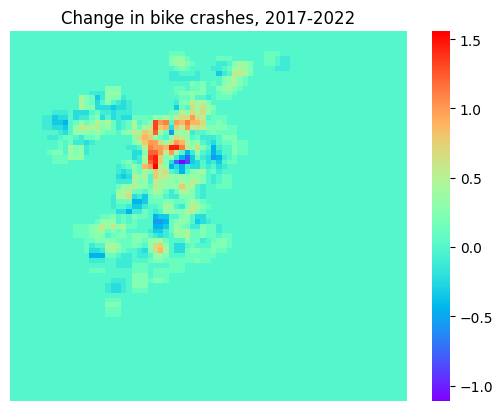

In [188]:
bike_crashes_2017_2022 = np.zeros((75,75)) 

for lat, long in zip(bike_crashes_2017.lat, bike_crashes_2017.long):
    # i = (max_lat - lat) / (max_lat - min_lat) / M
    i = (42.4 - float(lat)) / ((42.4 - 42.2) / 75)
    i = int(round(i))
    # j = (long - min_long) / (max_long - min_long) / N
    j = (float(long) - (-71.2)) / ((-70.9 - -71.2) / 75)
    j = int(round(j))
    # append cell with increased crash count
    bike_crashes_2017_2022[i, j] += 1

for lat, long in zip(bike_crashes_2022.lat, bike_crashes_2022.long):
    # i = (max_lat - lat) / (max_lat - min_lat) / M
    i = (42.4 - float(lat)) / ((42.4 - 42.2) / 75)
    i = int(round(i))
    # j = (long - min_long) / (max_long - min_long) / N
    j = (float(long) - (-71.2)) / ((-70.9 - -71.2) / 75)
    j = int(round(j))
    # append cell with increased crash count
    bike_crashes_2017_2022[i, j] -= 1    
    
    
    
import scipy.ndimage as ndi


# Create a 3x3 convolution blur
kernel = np.full((3, 3), 1 / 9)
# Apply convolutional blur to data
bike_crashes_2017_2022 = ndi.convolve(bike_crashes_2017_2022, kernel)

plt.axis('off')
plt.title("Change in bike crashes, 2017-2022")
sns.heatmap(bike_crashes_2017_2022, cmap='rainbow')

In [193]:
# create map item
crashmap_2017 = folium.Map(location = [42.3601, -71.0589], zoom_start=13) 

# extract lat long data from bike crash data
bike_crashes_2017_loc = bike_crashes_2017[['lat', 'long']]

# turn into a list of lists of lat, long data
heatmap_data = [[row['lat'], row['long']] for _, row in bike_crashes_2017_loc.iterrows()]

# create heatmap
HeatMap(heatmap_data).add_to(crashmap_2017)

# add bike lane GeoJson data to map
layer = folium.GeoJson(open(bike_lanes_geojson, "r").read())
layer.add_to(crashmap_2017)


# display map
crashmap_2017

## Alex's Work In Progress Stuff

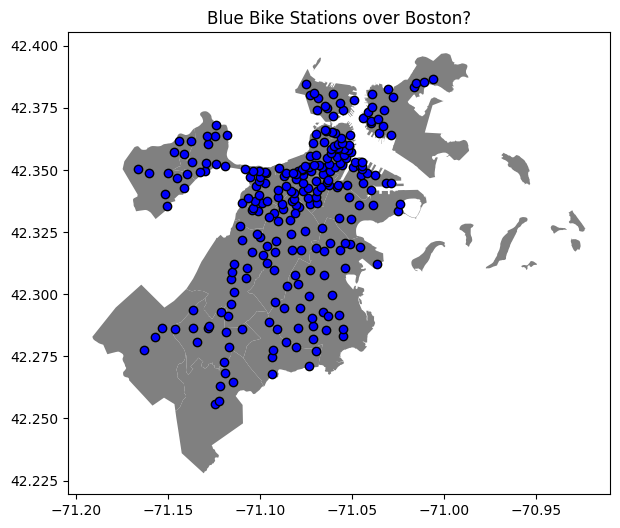

In [15]:
stations = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)

# mapping a dataframe with lat/long data to a point file
points = [Point(xy) for xy in zip(stations['Longitude'], stations['Latitude'])]

# convert that point layer into a geodataframe object
stations = gpd.GeoDataFrame(stations, crs="EPSG:4326", geometry=points)

# shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = gpd.read_file(boston_city_shp, type='Polygon')
boston_neighborhoods = boston_neighborhoods.to_crs('EPSG:4326')

# clip stations to the boston neighborhood map
clipped_stations = gpd.clip(stations, boston_neighborhoods, keep_geom_type=False)

# create figure
fig, ax = plt.subplots(figsize=(7, 7))

# Plot map
boston_neighborhoods.plot(ax=ax, color='grey')

# plot station data
clipped_stations.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='b')
plt.title("Blue Bike Stations over Boston?")
plt.show()

Nothing crazy just basic incase we need it for our report.

/var/folders/s0/8ys2gvm954l0zln605l0tpwr0000gn/T/ipykernel_5117/3762462597.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crash_data['geometry'] = [Point(xy) for xy in zip(crash_data['long'], crash_data['lat'])]


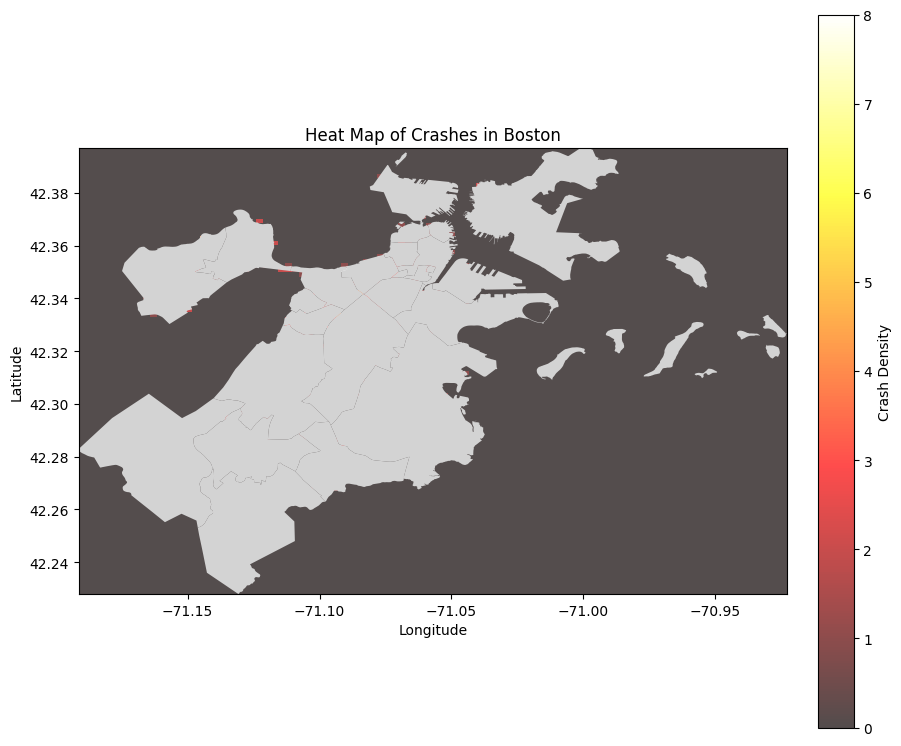

In [16]:
# Filter crash data to just bikes
crash_data = boston_crashes_2017[boston_crashes_2017["mode_type"] == 'bike']

# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_map = gpd.read_file(boston_city_shp, type='Polygon')
boston_map = boston_map.to_crs('EPSG:4326')

# Step 2: Prepare the Data
crash_data['geometry'] = [Point(xy) for xy in zip(crash_data['long'], crash_data['lat'])]
crash_data = gpd.GeoDataFrame(crash_data, geometry='geometry')


# Step 3: Prepare the Data
xmin, ymin, xmax, ymax = boston_map.total_bounds
density, x_edges, y_edges = np.histogram2d(
    crash_data.geometry.x, crash_data.geometry.y,
    bins=100, range=[[xmin, xmax], [ymin, ymax]]
)

# Plot the Map and Heat Map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the  Map of Boston
boston_map.plot(ax=ax, color='lightgray')

# Plot the Heat Map
extent = [xmin, xmax, ymin, ymax]
im = ax.imshow(density.T, origin='lower', extent=extent, cmap='hot', alpha=0.7)

# Add a Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Crash Density')

plt.title('Heat Map of Crashes in Boston')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# issue: heat map is being plotted under the map of boston
# issue: not really a heat map more of a histogram of where crashes are occuring? 
# not really what I wanted to make? I used geoplots to create

I was trying to create a heatmap of crashes over boston, but I used geoplots in my homework 2 and it managed to uninstall from my laptop lol. 

Did you make a heat map for HW 2? If so what did you use

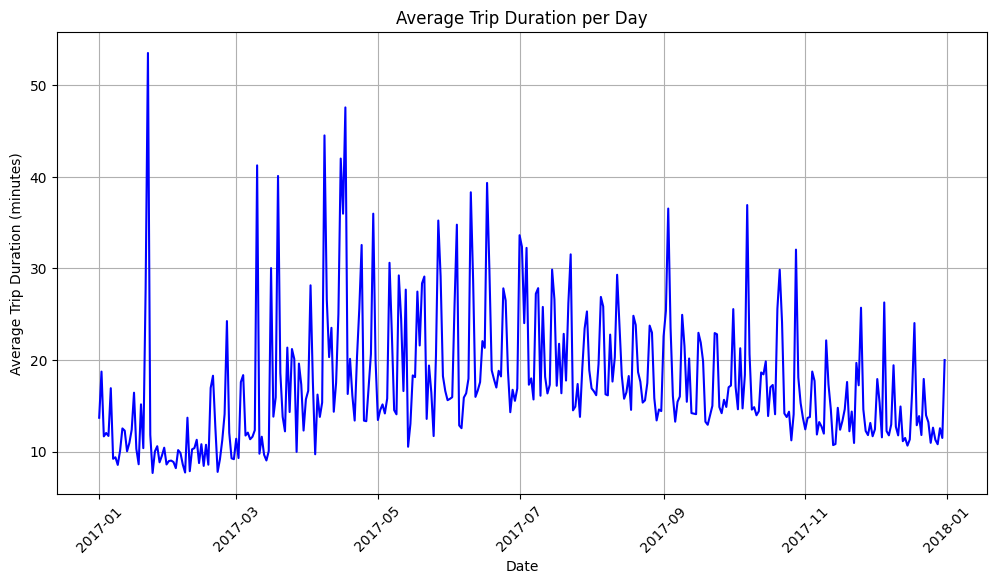

In [17]:
## Avg. Duration by Day -- not super relevent to us  --- if we do use this I will add a yearly average line in

blue_bike_trip_data = pd.read_sql("SELECT tripduration, starttime, stoptime FROM bluebike_trips2017", con)

# change to date types in pd
blue_bike_trip_data['starttime'] = pd.to_datetime(blue_bike_trip_data['starttime'])
blue_bike_trip_data['stoptime'] = pd.to_datetime(blue_bike_trip_data['stoptime'])

# convert trip duration from seconds to minutes
blue_bike_trip_data['tripduration'] = blue_bike_trip_data['tripduration'] / 60

# calculate average daily trip duration
daily_avg_trip_duration = blue_bike_trip_data.groupby(blue_bike_trip_data['starttime'].dt.date)['tripduration'].mean()

# plot
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_trip_duration.index, daily_avg_trip_duration, color='blue')

plt.title('Average Trip Duration per Day')
plt.xlabel('Date')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

In [18]:
## Attempt in show average distance from each station  -- need to fix the merge 

# query data
blue_bike_trip_data = pd.read_sql("SELECT * FROM bluebike_trips2022", con)
blue_bike_station_data =  pd.read_sql("SELECT * FROM current_bluebikes_stations", con)


# calcaulate avg & group 
station_duration_data = blue_bike_trip_data.groupby(['start_station_id', 'end_station_id'])['tripduration'].mean().reset_index()

# create geo for stations 
start_station_mapping = blue_bike_station_data[['station_id', 'start_station_latitude', 'start_station_longitude']]
start_station_mapping = start_station_mapping.rename(columns={'start_station_latitude': 'latitude_start', 'start_station_longitude': 'longitude_start'})
end_station_mapping = blue_bike_station_data[['station_id', 'end_station_latitude', 'end_station_longitude']]
end_station_mapping = end_station_mapping.rename(columns={'end_station_latitude': 'latitude_end', 'end_station_longitude': 'longitude_end'})

# join trip with station data 
station_duration_data = station_duration_data.join(start_station_mapping.set_index('station_id'), on='start_station_id')
station_duration_data = station_duration_data.join(end_station_mapping.set_index('station_id'), on='end_station_id')

# plot
gdf = gpd.GeoDataFrame(station_duration_data, geometry=gpd.points_from_xy(station_duration_data['longitude_start'], station_duration_data['latitude_start']))

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='tripduration', cmap='viridis', ax=ax, markersize=10, legend=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Trip Duration by Station Pair')

plt.show()

KeyError: "None of [Index(['station_id', 'start_station_latitude', 'start_station_longitude'], dtype='object')] are in the [columns]"

Viz ideas:
Heatmaps: how the most popular bike trip routes based on start and end stations
Heatmaps: show heat map of crashes in boston

Time of day people are biking and when crashes occur


Table: 
station & average distance 

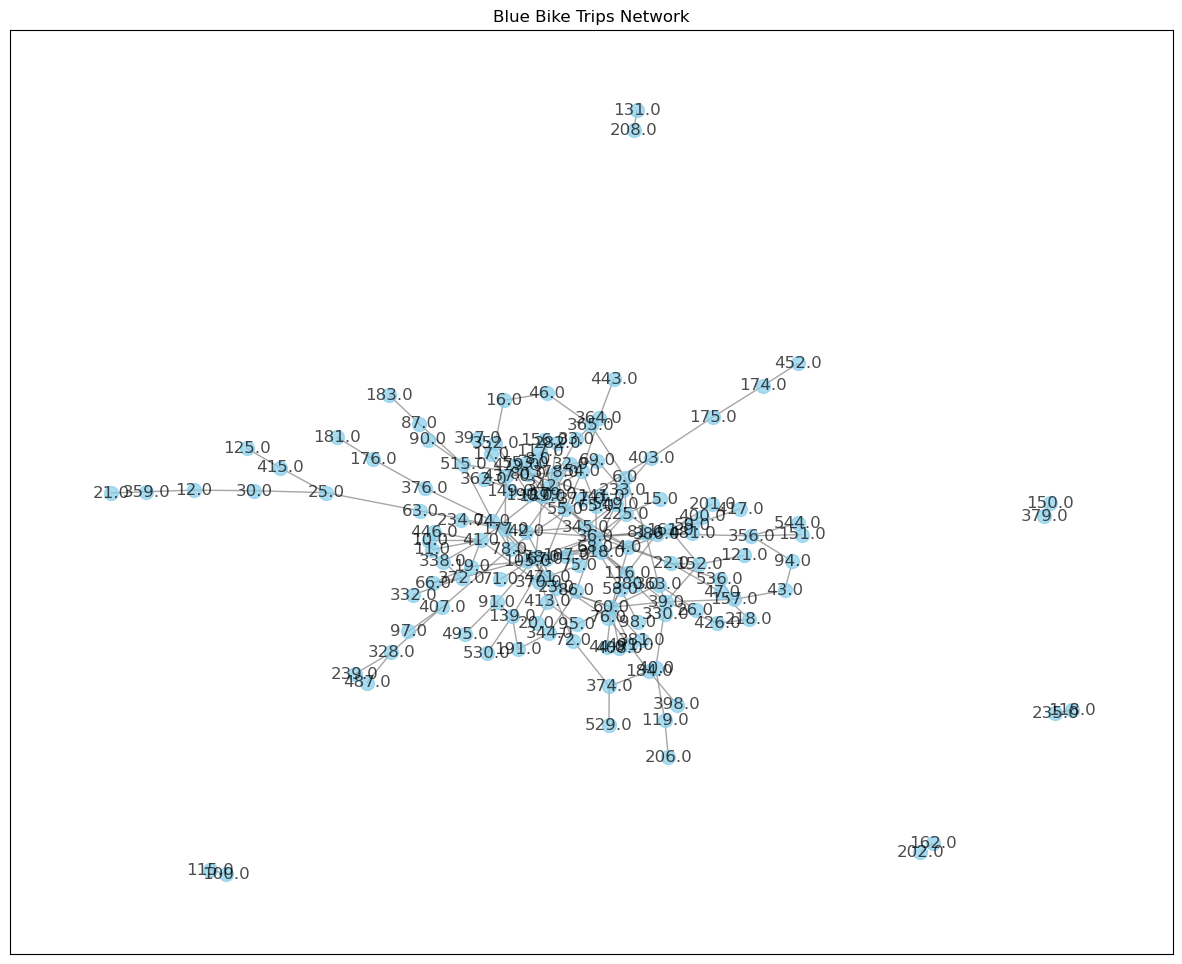

In [32]:
## showing a network of 250 trips--- excluding when people start and end at the same station


blue_bike_trip_data = pd.read_sql("SELECT start_station_latitude, start_station_longitude, start_station_id, end_station_id, end_station_latitude, end_station_longitude  FROM bluebike_trips2022", con)

bike_network = nx.Graph()

# iterate over each trip and add edges to the network
count = 0
for _, trip in blue_bike_trip_data.iterrows():
    # if stat station long is wihtin -71.2 and -70.95, and start station lat is within 42.2 and 42.40
    if (42.20 <= trip['start_station_latitude'] <= 42.40) and (-71.2 <= trip['start_station_longitude'] <= -70.95) and (42.20 <= trip['end_station_latitude'] <= 42.40) and (-71.2 <= trip['end_station_longitude'] <= -70.95):
        start_station = trip['start_station_id']
        end_station = trip['end_station_id']
        
        # exclude trip when people start and end at the same station
        if trip['start_station_id'] != trip['end_station_id']:
            bike_network.add_edge(start_station, end_station)
            count = count +1
    # only have 250 bikes in the network or its too messy
    if count >= 250:
        break

# plot the network
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(bike_network, seed=42)
nx.draw_networkx(bike_network, pos, node_size=100, node_color='skyblue', edge_color='gray', alpha=0.7)

plt.title('Blue Bike Trips Network')
plt.legend
plt.axis()
plt.show()

Network of 250 blue bike trips in 2022. Not including bikes that start and end at the same station. This is looking at who is comuting where. It would be cool to plot this over the map of boston but idk if I can figure that out in time. 

Need to add station names, so that we can actual see where people are going if we just keep this network view

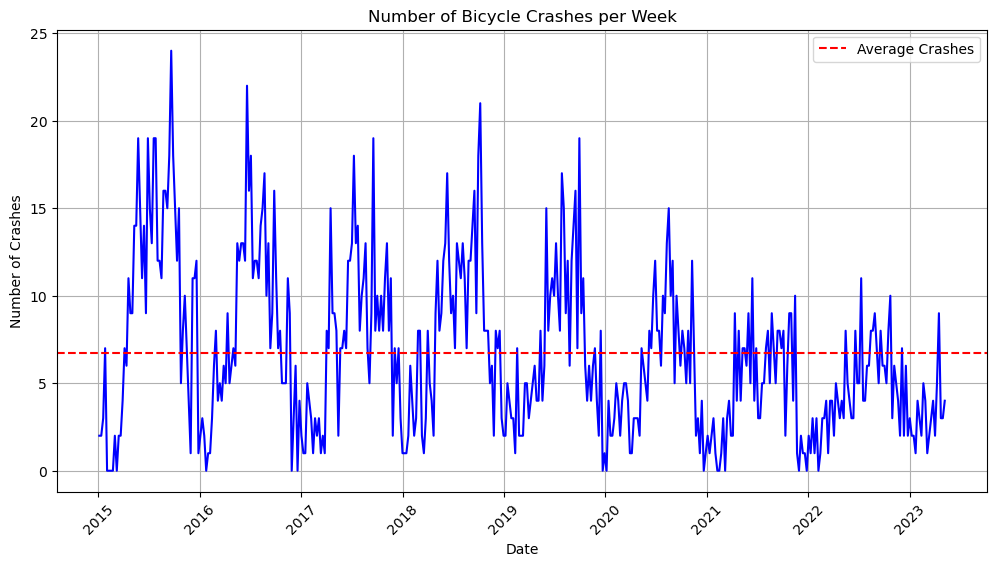

In [33]:
bos_crashes = pd.read_sql("SELECT * FROM boston_crash_reports", con)
bos_crashes = bos_crashes[bos_crashes["mode_type"] == 'bike'] #filter to just 

# convert column to datetime
bos_crashes['dispatch_ts'] = pd.to_datetime(bos_crashes['dispatch_ts'])

# group by week and count the number of crashes per week
crashes_per_week = bos_crashes.groupby(pd.Grouper(key='dispatch_ts', freq='W')).size()

# calculate the average crashes per week
average_crashes = crashes_per_week.mean()

# plot 
plt.figure(figsize=(12, 6))
plt.plot(crashes_per_week.index, crashes_per_week, color='blue')
plt.axhline(y=average_crashes, color='red', linestyle='--', label='Average Crashes')

plt.title('Number of Bicycle Crashes per Week')
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()


Kind of intresting to look at. I have seen things saying a lot of the bike lanes are new so it could be that new bike lanes are decreasing crashes, or less people are reporting crashes to the police. ? Not really sure how we will be able to use this


In [34]:
## Was trying to show the bike lanes affected by climate change 
## -- working on a way to show bike lanes that will be affected?

# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = gpd.read_file(boston_city_shp, type='Polygon')
boston_neighborhoods = boston_map.to_crs('EPSG:4326')

# Read data
bike_lanes = gpd.read_file(bike_lanes_geojson)
sea_level_rise = gpd.read_file(sea_level_36in_path)

# create plot
fig, ax = plt.subplots(figsize=(12, 8))

# plot 
boston_neighborhoods.plot(ax=ax)
bike_lanes.plot(ax=ax, color='blue')
plt.title('Bike Lanes in Boston')
plt.show()

NameError: name 'boston_map' is not defined